<a href="https://colab.research.google.com/github/ndevar132/demo-repo/blob/master/tf_cnn_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

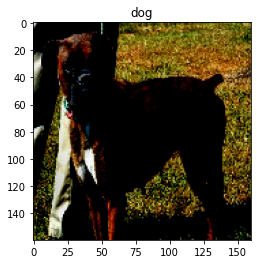

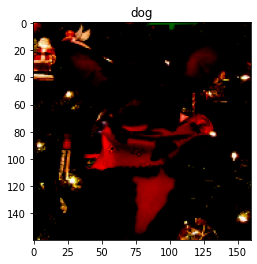

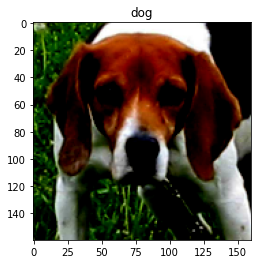

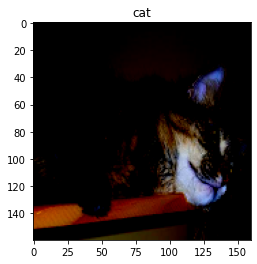

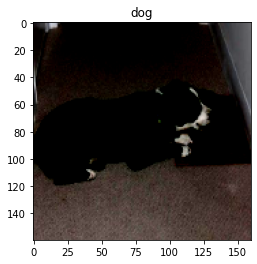

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# split data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata=tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

get_label_name = metadata.features['label'].int2str

# # display 2 images from dataset
# for image, label in raw_train.take(5):
#   plt.figure()
#   plt.imshow(image)
#   plt.title(get_label_name(label))

# preprocess
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# display 2 images from dataset
for image, label in train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

# shuffle
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)





In [0]:
# pic pretrained model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# create base model from model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # not include classifier
                                               weights='imagenet') # saved weight

In [0]:
base_model.summary()

In [0]:
for image, _ in train_batches.take(1):
  pass

feature_batch = base_model(image)
print(feature_batch.shape)

# freezing base
base_model.trainable = False

base_model.summary()

In [24]:
# adding own classifier
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1) # output layer

# combine model
model = tf.keras.Sequential([
                             base_model,
                             global_average_layer,
                             prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
# train
base_learning_rate = .0001 # low
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # two classes
              metrics=['accuracy'])

initial_epochs = 1
validation_steps = 20

# before train
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 12s 592ms/step - loss: 0.0841 - accuracy: 0.9672


In [28]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

582/582 [==============================] - 405s 696ms/step - loss: 0.0692 - accuracy: 0.9758 - val_loss: 0.0632 - val_accuracy: 0.9733
[0.97581946849823]


In [0]:
model.save("dogs_vs_cats.h5")
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')